# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Auto-configure CUDA paths for Windows if installed via pip/uv
import os
import platform
import sys

if platform.system() == 'Windows':
    try:
        import nvidia.cudnn.lib
        import nvidia.cublas.lib
        
        cudnn_dir = os.path.dirname(nvidia.cudnn.lib.__file__)
        cublas_dir = os.path.dirname(nvidia.cublas.lib.__file__)
        
        # Add to PATH
        os.environ['PATH'] = cudnn_dir + os.pathsep + cublas_dir + os.pathsep + os.environ['PATH']
        
        # Also, we might need 'bin' dirs for some packages if they structure it that way
        # But nvidia-cudnn-cu11 on pypi usually puts dlls in the package dir or lib dir.
        print(f"Added CUDA paths: {cudnn_dir}")
    except ImportError:
        print("NVIDIA python packages not found, falling back to system PATH for CUDA.")


# Load Python Libraries
import math
from tensorflow import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
import tensorflow as tf
tf.random.set_seed(42)

NVIDIA python packages not found, falling back to system PATH for CUDA.


In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date

In [5]:
# Plot the Close Data

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
print(data.isnull().sum())

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [7]:
data.fillna(method='ffill', inplace=True)

C:\Users\fady8\AppData\Local\Temp\ipykernel_21656\2866031220.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [8]:
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


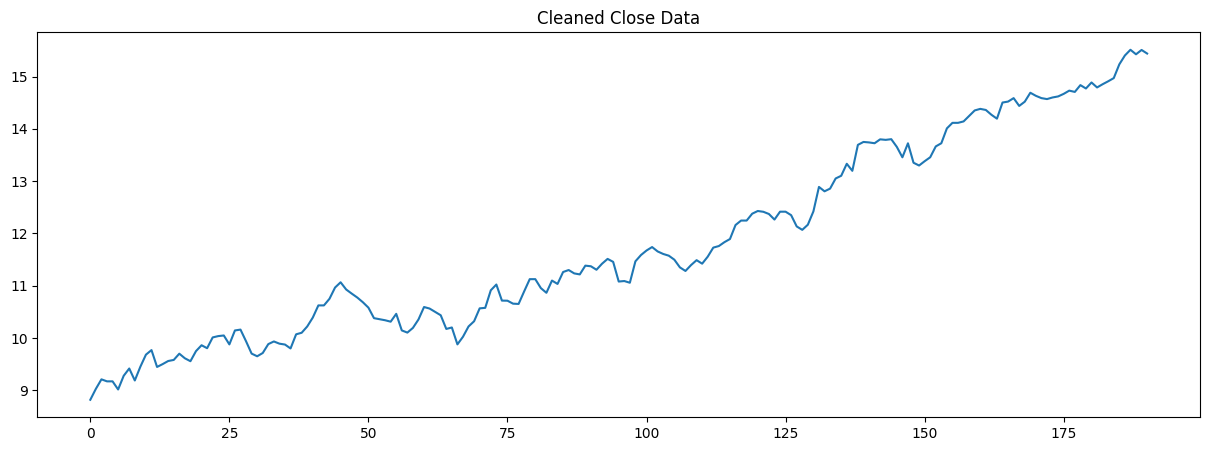

In [9]:
plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.title('Cleaned Close Data')
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
data['MA20'] = data['Close'].rolling(window=20).mean()
data['20dSTD'] = data['Close'].rolling(window=20).std()
data['Upper'] = data['MA20'] + (data['20dSTD'] * 2)
data['Lower'] = data['MA20'] - (data['20dSTD'] * 2)

In [11]:
# Remove rows with NaN bollinger bands
data = data.dropna()

In [12]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'Upper', 'Lower']]

# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [13]:
# Display & Plot Un-normalized Dataset

In [14]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values 
    normalizer.fit(column_data)
    normed_dataset[col] = normalizer.transform(column_data).flatten()
    normlist.append(normalizer)

In [15]:
# Display & Plot Normalized Dataset

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [16]:
# split dataset df into train (50%) and test (50%) datasets
l = len(normed_dataset)
train_len = int(l/2)

train_df = normed_dataset.iloc[:train_len]
test_df = normed_dataset.iloc[train_len:]

In [17]:
# display train and test dfs (ensure no overlap)

In [18]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
print(f'X_train shape: {X_train.shape}')

idx_close = 0 # numerical idx of close data column in array
idx_bb_upper = 1 # numerical idx of BB Upper data column in array
idx_bb_lower = 2 # numerical idx of BB Lower data column in array

X_train shape: (86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [19]:
@keras.utils.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        # define model layers in keras
        self.model = keras.Sequential([
            keras.layers.Input(shape=(state_size,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(action_size, activation='linear')
        ])
        # compile model in keras
        self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [20]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size 
        self.num_features = num_features 
        self.state_size = (window_size + 1) * num_features # fixed to include window history + current
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) 
        self.inventory = [] 
        self.model_name = model_name 
        self.test_mode = test_mode 
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size), verbose=0)
    
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    
    def act(self, state): 
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.get_q_values_for_state(state)
        return np.argmax(act_values[0])
 
    def exp_replay(self, batch_size, losses):
        if len(self.memory) < batch_size:
            return losses
        
        mini_batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in mini_batch:
            if done:
                target = reward  
            else:
                target = reward + self.gamma * np.amax(self.get_q_values_for_state(next_state)[0])
            
            target_f = self.get_q_values_for_state(state)
            target_f[0][action] = target
            
            history = self.fit_model(state, target_f)
            losses += history.history['loss']
           
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [21]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        # Simplified xticks for performance
        pass
    else:
        pass
    plt.show()

def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

def get_state(data, t, n): 
    # n is state size in days (window_size + 1)
    d = t - n + 1
    if d >= 0:
        window = data[d:t + 1]
    else:
        # Pad with first row
        padding = np.array([data[0]] * (-d))
        window = np.concatenate((padding, data[0:t+1]))
        
    res = []
    for i in range(n):
        for feature in window[i]:
            res.append(sigmoid(feature))
    return np.array([res])

### Training Loop

In [22]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set

In [23]:
# keras.utils.disable_interactive_logging() 
window_size = 1
agent = Agent(window_size, num_features=X_train.shape[1])

Running episode 0/2:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 0
Total Profit: $8.38
Total Winners: $11.17
Total Losers: $2.79
--------------------------------


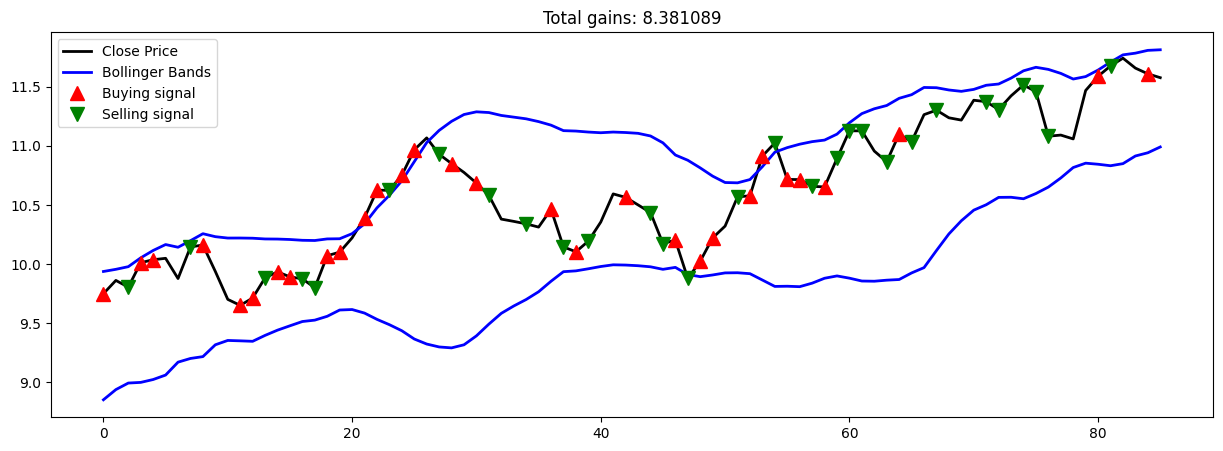

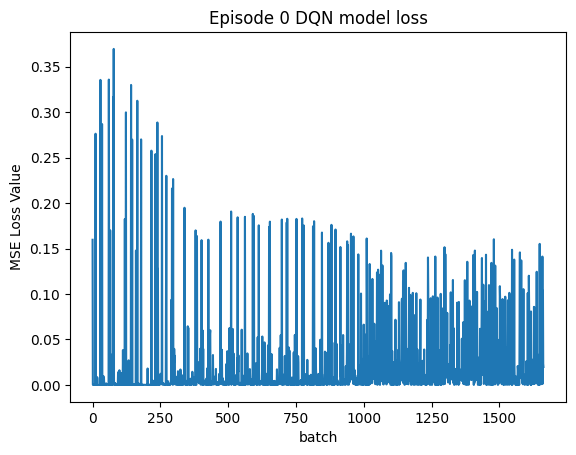

Running episode 1/2:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 1
Total Profit: $0.58
Total Winners: $2.50
Total Losers: $1.93
--------------------------------


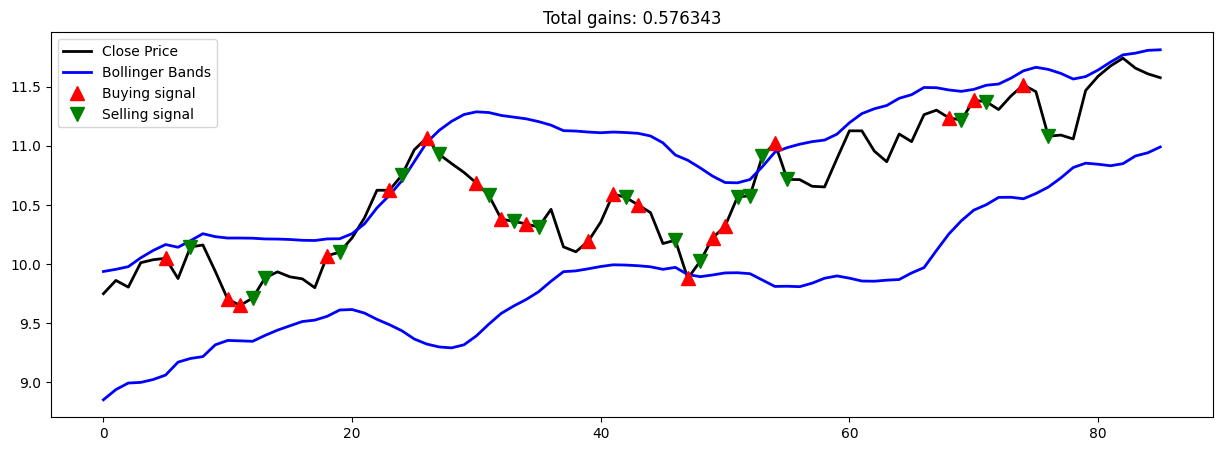

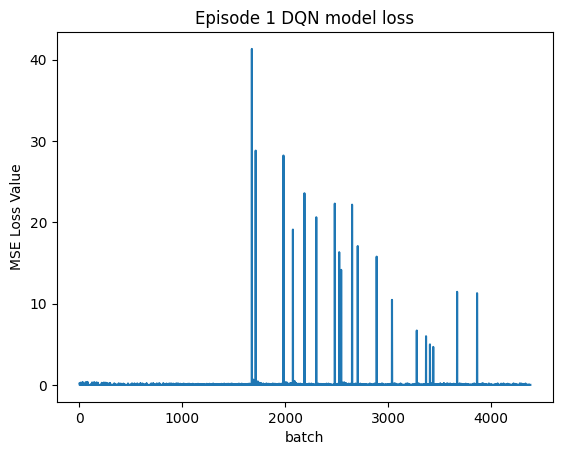

Running episode 2/2:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 2
Total Profit: $0.06
Total Winners: $0.94
Total Losers: $0.87
--------------------------------


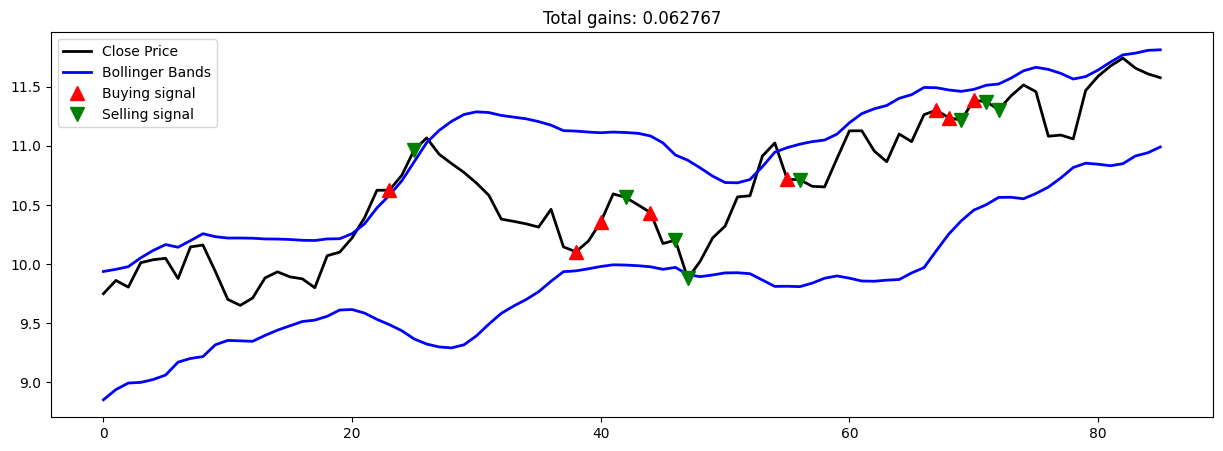

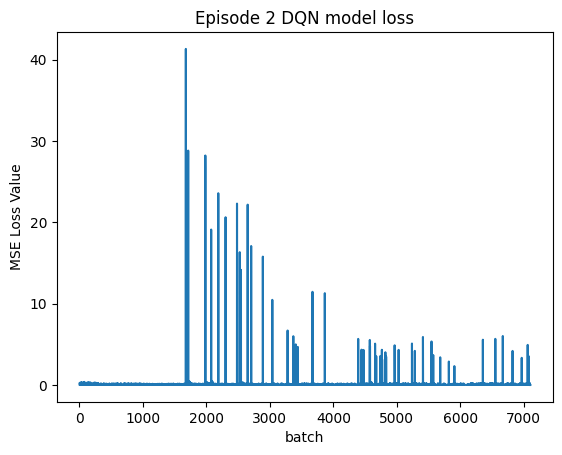

In [24]:
# keras.config.disable_traceback_filtering()

l = len(X_train) - 1
batch_size = 32
episode_count = 2

normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1, 1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1)).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size + 1)
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            buy_price = X_train_true_price[t]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            # print(f"Buy: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)  
            sell_price = X_train_true_price[t]
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += abs(trade_profit)
            states_sell.append(t)
            # print(f"Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}")

        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses, f'Episode {e} DQN model loss')
            
        if len(agent.memory) > batch_size:
            agent.exp_replay(batch_size, batch_losses)
            
    if e % 2 == 0:
        agent.model.save(f'model_ep{e}.keras')

### Plot Training Loss

In [25]:
# use the plot_losses function to plot all batch_losses for the entire training round

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [26]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

state = get_state(X_test, 0, window_size + 1)

X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1, 1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1)).flatten()

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

------------------------------------------
Total Profit: $0.00
------------------------------------------


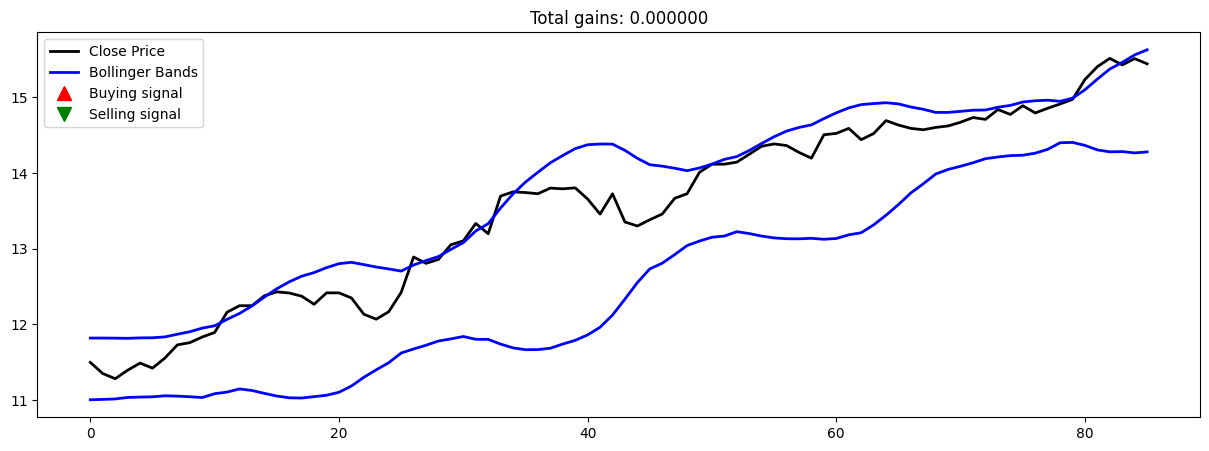

In [27]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        buy_price = X_test_true_price[t]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        sell_price = X_test_true_price[t]
        trade_profit = sell_price - bought_price
        total_profit += trade_profit
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

    if t == l_test - 1:
        done = True
    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')
        
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)